# Interaction Classification (Decision Tree) — Risk + Behavior

## Purpose
This notebook builds a **small, interpretable classifier** to automatically categorize ship–ship interactions using the **interaction-level behavioral features** in `behavior_summary.csv`.

## Inputs
- `behavior_summary.csv` (one row per interaction)

## Output
- A trained decision tree classifier
- Interpretable rules (text form)
- Feature importance
- Basic evaluation (train/test split)


In [2]:
import pandas as pd
import numpy as np

# =========================
# Load behavior summary
# =========================
behavior = pd.read_csv(
    "behavior_summary.csv",
    parse_dates=["start_time", "end_time"]
)

print("Loaded behavior_summary:", behavior.shape)

# =========================
# Filter interactions with sufficient temporal support
# =========================
MIN_POINTS = 3

behavior = behavior[behavior["points_count"] >= MIN_POINTS].copy()
print("After filtering points_count >= 3:", behavior.shape)

# =========================
# Remove missing risk values
# =========================
behavior = behavior.dropna(subset=["min_dcpa_m", "tcpa_s"]).copy()
print("After dropping NaN risk values:", behavior.shape)

behavior.head()


Loaded behavior_summary: (26946, 24)
After filtering points_count >= 3: (20538, 24)
After dropping NaN risk values: (20537, 24)


,ship_low,ship_high,interaction_id,start_time,end_time,duration_min,points_count,min_dcpa_m,tcpa_s,net_speed_change_1_kn,...,total_turn_2_deg,max_turn_rate_1_deg_s,max_turn_rate_2_deg_s,maneuvered_1,maneuvered_2,dominance_1,dominance_2,region_type,mmsi_1_example,mmsi_2_example
2,205067000,248843000,1,2015-10-23 03:38:00,2015-10-23 05:48:00,130.0,5,1346.859584,0.000000,1.2,...,9.0,0.001000,0.008333,True,True,speed,speed,open_sea,205067000,248843000
4,205204000,211211220,0,2015-11-19 03:48:00,2015-11-19 06:36:00,168.0,19,2.128205,3793.636349,-6.0,...,211.2,0.055556,0.206667,True,True,course,course,open_sea,205204000,211211220
5,205204000,211211220,1,2015-11-23 10:15:00,2015-11-23 10:30:00,15.0,14,753.050060,0.000000,6.8,...,197.5,0.600000,0.806667,True,True,course,course,harbor,205204000,211211220
6,205204000,227005550,0,2015-10-02 06:22:00,2015-10-02 07:31:00,69.0,21,7.702577,31.582827,-8.7,...,1079.8,0.800000,2.953333,True,True,course,course,harbor,205204000,227005550
7,205204000,227008170,0,2015-10-02 07:32:00,2015-10-02 07:35:00,3.0,4,909.941919,76.710659,0.0,...,15.0,0.116667,0.216667,True,True,course,course,harbor,205204000,227008170


In [3]:
# =========================
# Define risk level
# =========================
def assign_risk_level(row):
    dcpa = row["min_dcpa_m"]
    tcpa = row["tcpa_s"]

    # High risk: very close and imminent
    if (dcpa <= 100) and (tcpa <= 15 * 60):
        return "high"

    # Medium risk: moderate separation or timing
    elif (dcpa <= 500) and (tcpa <= 30 * 60):
        return "medium"

    # Low risk: everything else
    else:
        return "low"

behavior["risk_level"] = behavior.apply(assign_risk_level, axis=1)

print(behavior["risk_level"].value_counts())


high      7763
low       6875
medium    5899
Name: risk_level, dtype: int64


In [4]:
# =========================
# Define behavioral response
# =========================
def behavior_response(row):
    m1 = row["maneuvered_1"]
    m2 = row["maneuvered_2"]

    if m1 and m2:
        return "both_maneuvered"
    elif m1 or m2:
        return "one_maneuvered"
    else:
        return "none_maneuvered"

behavior["behavior_response"] = behavior.apply(behavior_response, axis=1)

print(behavior["behavior_response"].value_counts())


both_maneuvered    18561
one_maneuvered      1878
none_maneuvered       98
Name: behavior_response, dtype: int64


In [5]:
# =========================
# Combine into final interaction class and merge passive
# =========================
behavior["interaction_class"] = (
    behavior["risk_level"] + "_" + behavior["behavior_response"]
)

print("Initial interaction classes:")
print(behavior["interaction_class"].value_counts())

# =========================
# Merge all passive interactions into a single 'passive' class
# =========================
behavior["interaction_class"] = behavior["interaction_class"].str.replace(
    r'^(low|medium|high)_none_maneuvered$', 'passive', regex=True
)

print("\nFinal interaction classes (after merging passive):")
print(behavior["interaction_class"].value_counts())

# =========================
# Select classifier features (aligned with thesis)
# =========================
# We predict interaction_class using behavioral response features only.
# Risk variables (DCPA, TCPA) are excluded to avoid leakage,
# since they were used to define the risk level in the labels.

feature_columns = [
    # Speed response
    "net_speed_change_1_kn",
    "net_speed_change_2_kn",

    # Course response
    "total_turn_1_deg",
    "total_turn_2_deg",

    # Maneuver intensity
    "max_accel_1_mps2",
    "max_accel_2_mps2",
    "max_turn_rate_1_deg_s",
    "max_turn_rate_2_deg_s",

    # Environment
    "region_type",
]

X = behavior[feature_columns].copy()

# Use the final merged interaction classes
y = behavior["interaction_class"].copy()

# Basic cleaning
X = X.replace([np.inf, -np.inf], np.nan)
mask = X.notna().all(axis=1) & y.notna()
X = X.loc[mask]
y = y.loc[mask]

print("Feature matrix shape:", X.shape)
print("Target shape:", y.shape)
print("\nClass distribution:")
print(y.value_counts())



print("\nFinal classes for training:")
print(y.value_counts())

Initial interaction classes:
high_both_maneuvered      7695
medium_both_maneuvered    5685
low_both_maneuvered       5181
low_one_maneuvered        1608
medium_one_maneuvered      204
low_none_maneuvered         86
high_one_maneuvered         66
medium_none_maneuvered      10
high_none_maneuvered         2
Name: interaction_class, dtype: int64

Final interaction classes (after merging passive):
high_both_maneuvered      7695
medium_both_maneuvered    5685
low_both_maneuvered       5181
low_one_maneuvered        1608
medium_one_maneuvered      204
passive                     98
high_one_maneuvered         66
Name: interaction_class, dtype: int64
Feature matrix shape: (20537, 9)
Target shape: (20537,)

Class distribution:
high_both_maneuvered      7695
medium_both_maneuvered    5685
low_both_maneuvered       5181
low_one_maneuvered        1608
medium_one_maneuvered      204
passive                     98
high_one_maneuvered         66
Name: interaction_class, dtype: int64

Final classes 

In [6]:
# =========================
# Encode categorical features
# =========================

X = pd.get_dummies(X, columns=["region_type"], drop_first=True)

print("Encoded feature matrix shape:", X.shape)
X.head()


Encoded feature matrix shape: (20537, 9)


,net_speed_change_1_kn,net_speed_change_2_kn,total_turn_1_deg,total_turn_2_deg,max_accel_1_mps2,max_accel_2_mps2,max_turn_rate_1_deg_s,max_turn_rate_2_deg_s,region_type_open_sea
2,1.2,1.0,1.2,9.0,0.000094,0.000078,0.001000,0.008333,1
4,-6.0,-5.8,136.0,211.2,0.006859,0.006859,0.055556,0.206667,1
5,6.8,2.0,177.0,197.5,0.059161,0.009860,0.600000,0.806667,0
6,-8.7,-3.1,328.0,1079.8,0.028294,0.110605,0.800000,2.953333,0
7,0.0,0.8,18.0,15.0,0.001715,0.004287,0.116667,0.216667,0


In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.25,
    random_state=49,
    stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


Train size: (15402, 9)
Test size: (5135, 9)


In [8]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(
    max_depth=5,        # prevent overfitting
    min_samples_leaf=50,
    random_state=49
)

clf.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5, min_samples_leaf=50, random_state=49)

In [9]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Decision Tree accuracy: {accuracy:.3f}")


Decision Tree accuracy: 0.559


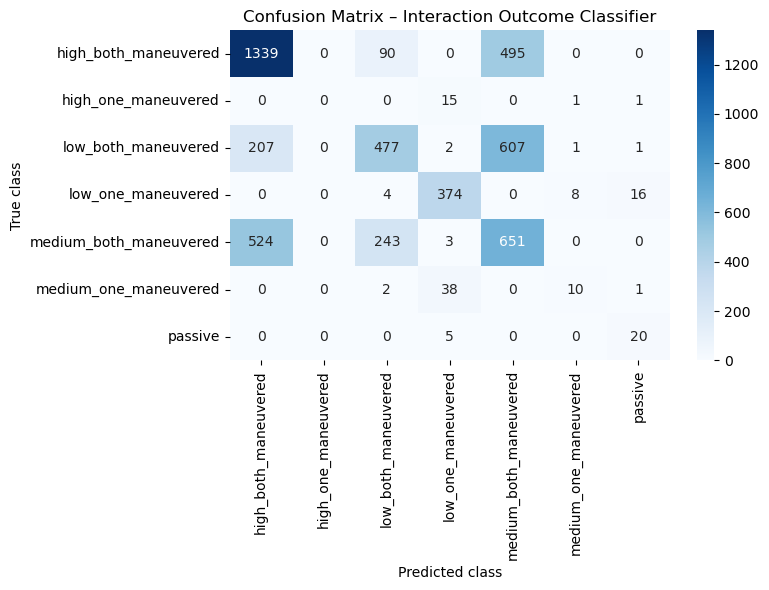


Classification report:
                        precision    recall  f1-score   support

  high_both_maneuvered       0.65      0.70      0.67      1924
   high_one_maneuvered       0.00      0.00      0.00        17
   low_both_maneuvered       0.58      0.37      0.45      1295
    low_one_maneuvered       0.86      0.93      0.89       402
medium_both_maneuvered       0.37      0.46      0.41      1421
 medium_one_maneuvered       0.50      0.20      0.28        51
               passive       0.51      0.80      0.62        25

              accuracy                           0.56      5135
             macro avg       0.50      0.49      0.48      5135
          weighted avg       0.57      0.56      0.55      5135



C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\HP\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=clf.classes_,
    yticklabels=clf.classes_,
    cmap="Blues"
)
plt.xlabel("Predicted class")
plt.ylabel("True class")
plt.title("Confusion Matrix – Interaction Outcome Classifier")
plt.tight_layout()
plt.show()

print("\nClassification report:")
print(classification_report(y_test, y_pred))


In [11]:
import pandas as pd

importance = pd.Series(
    clf.feature_importances_,
    index=X.columns
).sort_values(ascending=False)

print("Feature importance:")
importance


Feature importance:


total_turn_1_deg         0.470917
total_turn_2_deg         0.406868
max_accel_1_mps2         0.050010
max_accel_2_mps2         0.048478
net_speed_change_2_kn    0.018892
region_type_open_sea     0.003179
net_speed_change_1_kn    0.001655
max_turn_rate_1_deg_s    0.000000
max_turn_rate_2_deg_s    0.000000
dtype: float64

## Final Interpretation and Role of the Classifier

### What the Classifier Does

The classifier operates at the **interaction level**, using summarized AIS-derived features to assign each ship–ship interaction to a **combined behavioral class** that reflects:

- **Encounter risk level** (low / medium / high), derived from encounter geometry, and  
- **Observed behavioral response**, describing whether:
  - both ships maneuvered,
  - only one ship maneuvered, or
  - no clear maneuvering response was observed (passive).

The resulting interaction classes (e.g., *high_both_maneuvered*, *medium_one_maneuvered*, *low_passive*) are directly constructed from the interaction summaries and are consistent with the distributions observed in this notebook, where the majority of interactions fall into maneuvering categories and only a small fraction are passive.

The model therefore learns a mapping from **continuous interaction characteristics** (e.g., proximity, timing, maneuver intensity, and context) to **discrete behavioral outcomes**.

Importantly, the classifier does **not** predict future motion or collision events.  
It categorizes **already-observed interactions** based on their structural properties.

---

### Why the Classifier Is Included in the Thesis

The classifier is included for **methodological validation**, not operational deployment.

Specifically, it serves three purposes:

1. **Validation of Behavioral Structure**  
   Earlier visualization and statistical analysis revealed consistent relationships between:
   - encounter risk (DCPA/TCPA),
   - maneuver magnitude (speed and course changes), and
   - interaction outcomes.

   The learned interaction classes and their observed frequencies confirm that these relationships are **systematic and repeatable** across the dataset, rather than driven by isolated examples.

2. **Compact Representation of Interaction Behavior**  
   While raw AIS trajectories are high-dimensional, the classifier demonstrates that
   interaction behavior can be **meaningfully summarized and categorized** using a small,
   interpretable feature set derived at the interaction level.

3. **Foundation for Future Extensions**  
   The approach establishes a framework that could later be extended toward:
   - real-time monitoring,
   - anomaly detection,
   - or decision-support systems.

   These extensions are **explicitly outside the scope of this thesis**.

---

### What the Results Mean

Based on the classifier outputs and the resulting interaction class distributions, the following conclusions can be drawn:

- **Most interactions involve active maneuvering**, most commonly with both vessels responding, which aligns with the dominance of *both_maneuvered* classes observed in the results.
- **Higher-risk encounters** are associated with **stronger maneuvering responses**, particularly course changes, consistent with patterns identified in the visualization notebook.
- **Passive interactions are rare**, especially in medium- and high-risk categories, indicating that lack of response during close encounters is uncommon in the observed data.
- The classifier successfully distinguishes interaction classes using only interaction-level features, confirming that:
  
  > ship–ship behavior exhibits structured, repeatable patterns that are detectable in AIS data.

These results support the thesis claim that **risk context and behavioral response are tightly coupled** in real maritime traffic.

---

### What the Results Do *Not* Mean

It is equally important to clarify the limitations:

- The classifier **does not predict collisions**.
- It **does not forecast future maneuvers**.
- It **does not infer navigator intent or compliance with COLREGs**.
- It **does not operate on raw AIS streams in real time**.

Instead, the classifier provides an **analytical categorization tool** that helps explain
*how ships responded* during observed interactions.

---

### Class Imbalance and Interpretation

Some interaction classes (e.g., passive encounters in higher-risk categories) occur very infrequently in the dataset.
Rather than removing these cases entirely, passive interactions were merged into a single category to:

- preserve semantic meaning,
- avoid unstable subclasses,
- and reflect real-world rarity rather than data error.

This handling ensures statistical stability while maintaining interpretability.

---

### Final Assessment

This classifier completes the thesis pipeline by showing that:

> **Ship–ship interaction behavior can be systematically categorized using AIS-derived interaction features, linking encounter risk with observed maneuvering responses.**

It serves as a **conceptual and analytical endpoint** for the thesis, rather than a predictive system.

---